In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.image import resize
import time

In [3]:
train_csv = r'C:\Users\Adham\Downloads\data_set\train\emnist-letters-train.csv'
test_csv = r'C:\Users\Adham\Downloads\data_set\test\emnist-letters-test.csv'

In [4]:
train_df = pd.read_csv(train_csv, header=None)
test_df = pd.read_csv(test_csv, header=None)

In [5]:
y_train_full = train_df.iloc[:, 0].values
X_train_full = train_df.iloc[:, 1:].values

y_test = test_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values

In [6]:
print(f"   Training samples: {len(X_train_full):,}")
print(f"   Test samples: {len(X_test):,}")
print(f"   Pixels per image: {X_train_full.shape[1]}")
print(f"   Labels range: {y_train_full.min()} to {y_train_full.max()}")

   Training samples: 88,800
   Test samples: 14,800
   Pixels per image: 784
   Labels range: 1 to 26


In [9]:
X_train_full = X_train_full.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

In [10]:
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [11]:
y_train_full = y_train_full - 1
y_test = y_test - 1

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.15, 
    random_state=42,
    stratify=y_train_full
)

In [13]:
num_classes = len(np.unique(y_train))
class_names = [chr(65 + i) for i in range(num_classes)]

In [14]:
print(f"\n Data prepared successfully!")
print(f"   Training set: {X_train.shape}")
print(f"   Validation set: {X_val.shape}")
print(f"   Test set: {X_test.shape}")
print(f"   Number of classes: {num_classes}")
print(f"   Classes: {class_names}")


 Data prepared successfully!
   Training set: (75480, 28, 28)
   Validation set: (13320, 28, 28)
   Test set: (14800, 28, 28)
   Number of classes: 26
   Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


Text(0.5, 0.98, 'EMNIST Letters - Sample Images from Each Class')

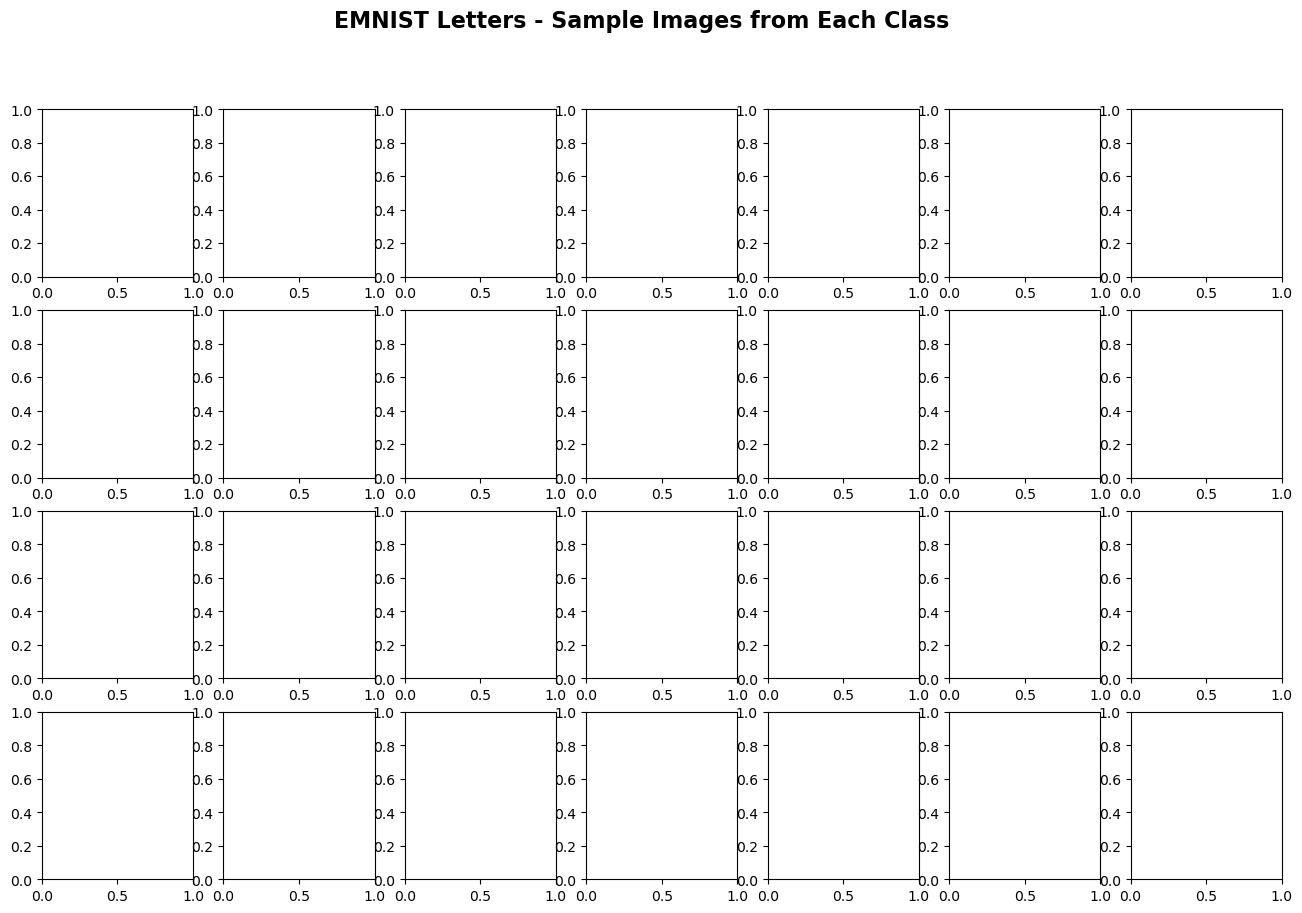

In [15]:
fig, axes = plt.subplots(4, 7, figsize=(16, 10))
fig.suptitle('EMNIST Letters - Sample Images from Each Class', 
             fontsize=16, fontweight='bold')

In [16]:
for i in range(min(26, num_classes)):
    idx = np.where(y_train == i)[0][0]
    row = i // 7
    col = i % 7
    axes[row, col].imshow(X_train[idx], cmap='gray')
    axes[row, col].set_title(f'Class: {class_names[i]}', fontweight='bold')
    axes[row, col].axis('off')

In [17]:
for i in range(num_classes, 28):
    row = i // 7
    col = i % 7
    if row < 4 and col < 7:
        axes[row, col].axis('off')

In [18]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

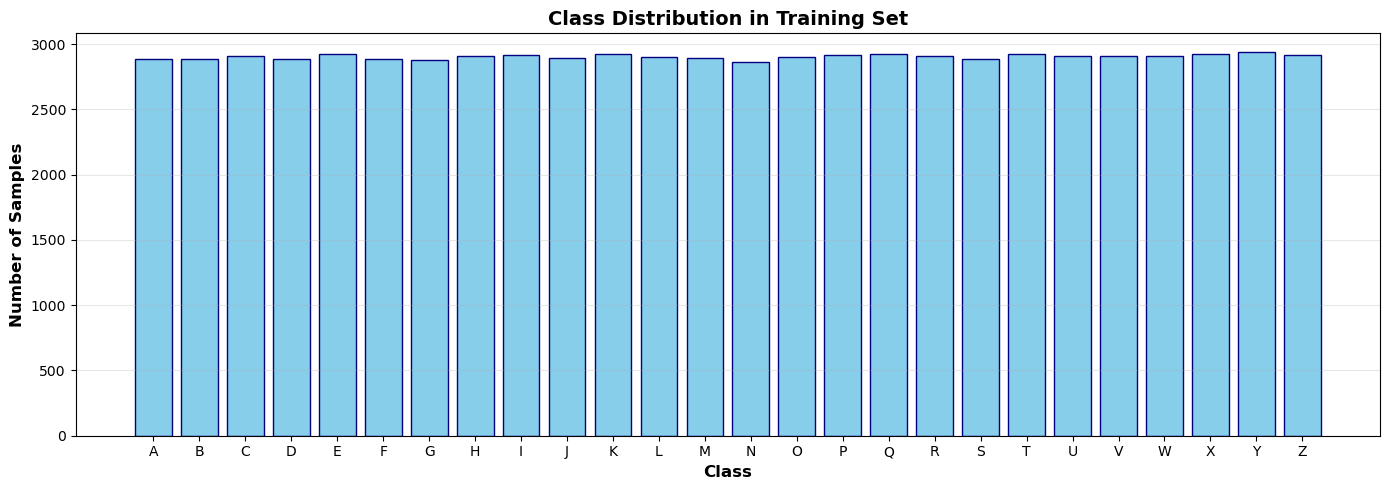

In [19]:
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(14, 5))
plt.bar([class_names[i] for i in unique], counts, color='skyblue', edgecolor='navy')
plt.xlabel('Class', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Class Distribution in Training Set', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
class_dist = pd.DataFrame({
    'Class': [class_names[i] for i in unique],
    'Count': counts,
    'Percentage': (counts / len(y_train) * 100).round(2)
})
print(class_dist.to_string(index=False))

Class  Count  Percentage
    A   2887        3.82
    B   2887        3.82
    C   2906        3.85
    D   2888        3.83
    E   2921        3.87
    F   2885        3.82
    G   2877        3.81
    H   2910        3.86
    I   2914        3.86
    J   2892        3.83
    K   2922        3.87
    L   2903        3.85
    M   2892        3.83
    N   2860        3.79
    O   2897        3.84
    P   2915        3.86
    Q   2920        3.87
    R   2906        3.85
    S   2883        3.82
    T   2921        3.87
    U   2906        3.85
    V   2909        3.85
    W   2910        3.86
    X   2921        3.87
    Y   2935        3.89
    Z   2913        3.86


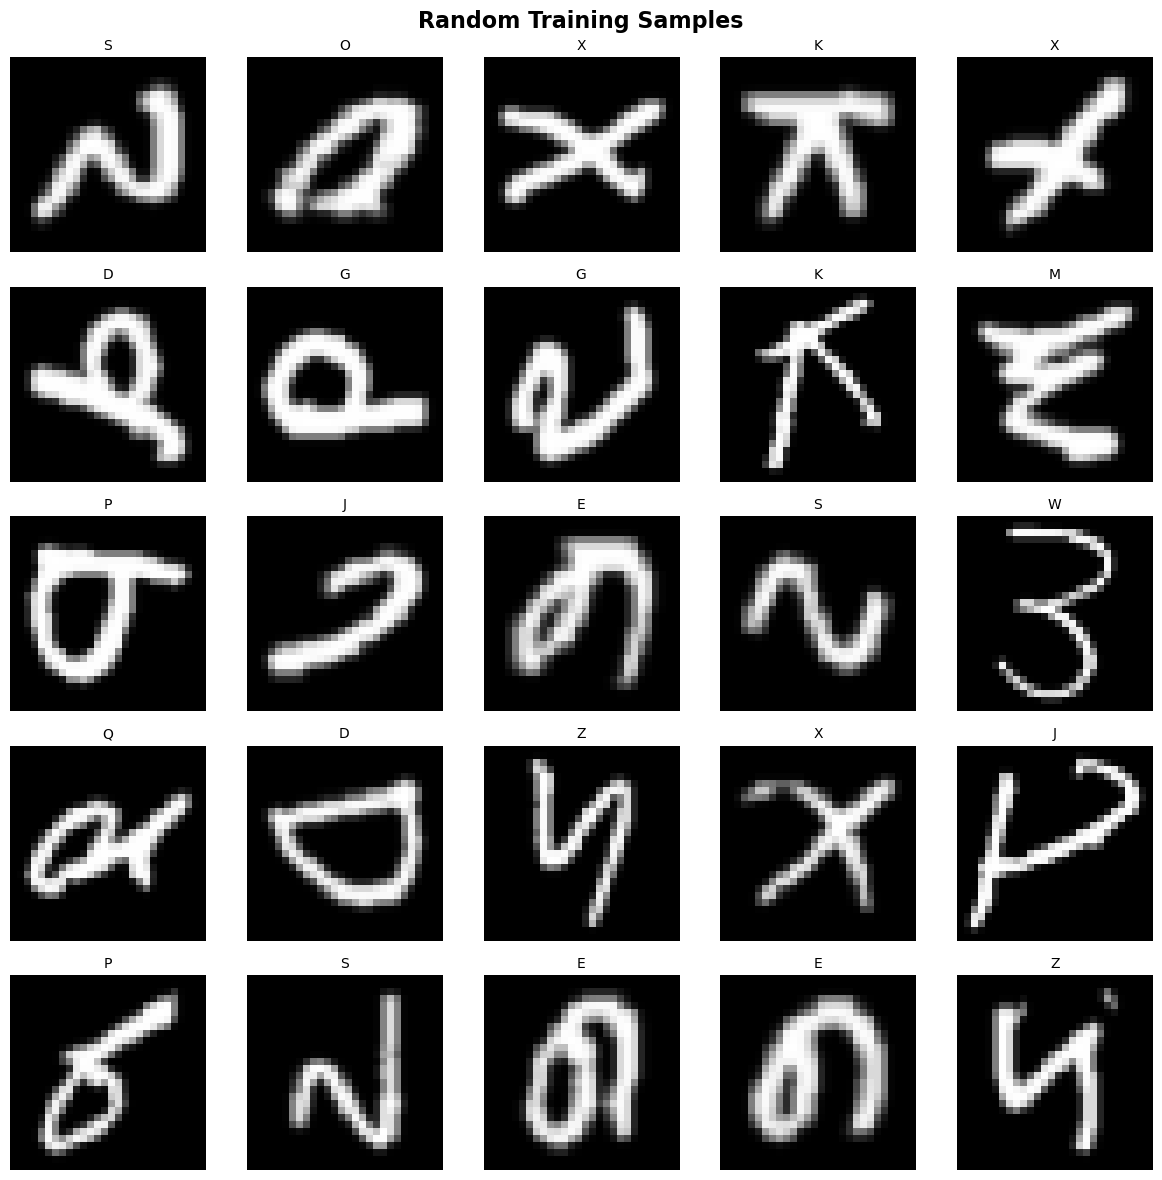

In [21]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
fig.suptitle('Random Training Samples', fontsize=16, fontweight='bold')
random_indices = np.random.choice(len(X_train), 25, replace=False)
for i, idx in enumerate(random_indices):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(X_train[idx], cmap='gray')
    axes[row, col].set_title(f'{class_names[y_train[idx]]}', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [22]:
def plot_training_history(history, model_name, color='blue'):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].plot(history.history['accuracy'], label='Training', linewidth=2, color=color)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2, color=color, linestyle='--')
    axes[0].set_title(f'{model_name}: Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[1].plot(history.history['loss'], label='Training', linewidth=2, color=color)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2, color=color, linestyle='--')
    axes[1].set_title(f'{model_name}: Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [23]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name, cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=class_names, yticklabels=class_names,cbar_kws={'label': 'Count'})
    plt.title(f'{model_name}: Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    return cm

In [24]:
def calculate_metrics(y_true, y_pred, class_names):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"\n Overall Metrics:")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    return accuracy, precision, recall, f1

In [25]:
def plot_roc_curves(y_true, y_pred_proba, num_classes, class_names, model_name):
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(min(num_classes, 10)):  
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    for i, color in enumerate(colors[:min(num_classes, 10)]):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title(f'{model_name}: ROC Curves (First 10 Classes)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    all_auc = [auc(fpr[i], tpr[i]) for i in range(min(num_classes, 10))]
    macro_auc = np.mean(all_auc)
    return macro_auc

In [26]:
def show_predictions(X, y_true, y_pred, class_names, model_name):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f'{model_name}: Predictions (Top: Correct, Bottom: Incorrect)', fontsize=14, fontweight='bold')
    correct_idx = np.where(y_pred == y_true)[0]
    if len(correct_idx) >= 5:
        correct_samples = np.random.choice(correct_idx, 5, replace=False)
    else:
        correct_samples = correct_idx
    
    for i in range(5):
        if i < len(correct_samples):
            idx = correct_samples[i]
            axes[0, i].imshow(X[idx], cmap='gray')
            axes[0, i].set_title(f'True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}',
                               color='green', fontweight='bold')
        axes[0, i].axis('off')
    
    incorrect_idx = np.where(y_pred != y_true)[0]
    if len(incorrect_idx) >= 5:
        incorrect_samples = np.random.choice(incorrect_idx, 5, replace=False)
    else:
        incorrect_samples = incorrect_idx
    
    for i in range(5):
        if i < len(incorrect_samples):
            idx = incorrect_samples[i]
            axes[1, i].imshow(X[idx], cmap='gray')
            axes[1, i].set_title(f'True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}',
                               color='red', fontweight='bold')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [27]:
X_train_vgg = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
X_val_vgg = np.repeat(X_val[..., np.newaxis], 3, axis=-1)
X_test_vgg = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

In [28]:
X_train_vgg = resize(X_train_vgg, [56, 56]).numpy()
X_val_vgg = resize(X_val_vgg, [56, 56]).numpy()
X_test_vgg = resize(X_test_vgg, [56, 56]).numpy()

In [29]:
y_train_vgg = to_categorical(y_train, num_classes)
y_val_vgg = to_categorical(y_val, num_classes)
y_test_vgg = to_categorical(y_test, num_classes)

In [30]:
print(f"Data prepared: {X_train_vgg.shape}")

Data prepared: (75480, 56, 56, 3)


In [31]:
vgg19_model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(56, 56, 3)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
], name='VGG19')

D:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
vgg19_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
print(f"Model built: {vgg19_model.count_params():,} parameters")

Model built: 12,958,298 parameters


In [34]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1), ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)]

In [ ]:
start_time = time.time()
history_vgg = vgg19_model.fit(
    X_train_vgg, y_train_vgg,
    batch_size=64,
    epochs=30,
    validation_data=(X_val_vgg, y_val_vgg),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
 393/1180 ━━━━━━━━━━━━━━━━━━━━ 19:44 2s/step - accuracy: 0.0365 - loss: 3.2606

In [ ]:
vgg_train_time = time.time() - start_time

In [ ]:
print(f"\nTraining completed in {vgg_train_time/60:.2f} minutes")
print(f"\n✓ Training completed in {vgg_train_time/60:.2f} minutes")

In [ ]:
plot_training_history(history_vgg, 'VGG-19', color='blue')

In [ ]:
start_time = time.time()
y_pred_proba_vgg = vgg19_model.predict(X_test_vgg, verbose=0)
vgg_inference_time = time.time() - start_time

In [ ]:
y_pred_vgg = np.argmax(y_pred_proba_vgg, axis=1)

In [ ]:
vgg_acc, vgg_prec, vgg_rec, vgg_f1 = calculate_metrics(y_test, y_pred_vgg, class_names)

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_vgg, target_names=class_names))

In [ ]:
plot_confusion_matrix(y_test, y_pred_vgg, class_names, 'VGG-19', cmap='Blues')

In [ ]:
vgg_auc = plot_roc_curves(y_test, y_pred_proba_vgg, num_classes, class_names, 'VGG-19')
print(f"\n✓ Macro-Average AUC: {vgg_auc:.4f}")

In [ ]:
show_predictions(X_test, y_test, y_pred_vgg, class_names, 'VGG-19')

In [ ]:
vgg19_model.save('vgg19_emnist.h5')
print("\nModel saved: vgg19_emnist.h5")

In [ ]:
results_vgg = {
    'accuracy': vgg_acc,
    'precision': vgg_prec,
    'recall': vgg_rec,
    'f1_score': vgg_f1,
    'auc': vgg_auc,
    'train_time': vgg_train_time,
    'inference_time': vgg_inference_time,
    'params': vgg19_model.count_params()
}

In [ ]:
X_train_resnet = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
X_val_resnet = np.repeat(X_val[..., np.newaxis], 3, axis=-1)
X_test_resnet = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

In [ ]:
X_train_resnet = resize(X_train_resnet, [224, 224]).numpy()
X_val_resnet = resize(X_val_resnet, [224, 224]).numpy()
X_test_resnet = resize(X_test_resnet, [224, 224]).numpy()

In [ ]:
y_train_resnet = to_categorical(y_train, num_classes)
y_val_resnet = to_categorical(y_val, num_classes)
y_test_resnet = to_categorical(y_test, num_classes)

In [ ]:
print(f"Data prepared: {X_train_resnet.shape}")

In [ ]:
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_resnet.trainable = False

In [ ]:
resnet_model = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
], name='ResNet50')

In [ ]:
resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
print(f"Model built: {resnet_model.count_params():,} parameters")

In [ ]:
start_time = time.time()
history_resnet = resnet_model.fit(
    X_train_resnet, y_train_resnet,
    batch_size=32,
    epochs=20,
    validation_data=(X_val_resnet, y_val_resnet),
    callbacks=callbacks,
    verbose=1
)
resnet_train_time = time.time() - start_time
print(f"\nTraining completed in {resnet_train_time/60:.2f} minutes")

In [ ]:
plot_training_history(history_resnet, 'ResNet-50', color='green')

In [ ]:
start_time = time.time()
y_pred_proba_resnet = resnet_model.predict(X_test_resnet, verbose=0)
resnet_inference_time = time.time() - start_time
y_pred_resnet = np.argmax(y_pred_proba_resnet, axis=1)
resnet_acc, resnet_prec, resnet_rec, resnet_f1 = calculate_metrics(y_test, y_pred_resnet, class_names)

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_resnet, target_names=class_names))

In [ ]:
plot_confusion_matrix(y_test, y_pred_resnet, class_names, 'ResNet-50', cmap='Greens')

In [ ]:
resnet_auc = plot_roc_curves(y_test, y_pred_proba_resnet, num_classes, class_names, 'ResNet-50')
print(f"\nMacro-Average AUC: {resnet_auc:.4f}")

In [ ]:
show_predictions(X_test, y_test, y_pred_resnet, class_names, 'ResNet-50')

In [ ]:
resnet_model.save('resnet50_emnist.h5')
print("\nModel saved: resnet50_emnist.h5")

In [ ]:
results_resnet = {
    'accuracy': resnet_acc,
    'precision': resnet_prec,
    'recall': resnet_rec,
    'f1_score': resnet_f1,
    'auc': resnet_auc,
    'train_time': resnet_train_time,
    'inference_time': resnet_inference_time,
    'params': resnet_model.count_params()
}

In [ ]:
X_train_inception = X_train_resnet
X_val_inception = X_val_resnet
X_test_inception = X_test_resnet
y_train_inception = y_train_resnet
y_val_inception = y_val_resnet
y_test_inception = y_test_resnet

In [ ]:
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_inception.trainable = False

inception_model = models.Sequential([
    base_inception,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
], name='InceptionV3')

In [ ]:
inception_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
print(f"Model built: {inception_model.count_params():,} parameters")

In [ ]:
start_time = time.time()
history_inception = inception_model.fit(
    X_train_inception, y_train_inception,
    batch_size=32,
    epochs=20,
    validation_data=(X_val_inception, y_val_inception),
    callbacks=callbacks,
    verbose=1
)
inception_train_time = time.time() - start_time
print(f"\nTraining completed in {inception_train_time/60:.2f} minutes")

In [ ]:
plot_training_history(history_inception, 'Inception V3', color='orange')

In [ ]:
start_time = time.time()
y_pred_proba_inception = inception_model.predict(X_test_inception, verbose=0)
inception_inference_time = time.time() - start_time
y_pred_inception = np.argmax(y_pred_proba_inception, axis=1)
inception_acc, inception_prec, inception_rec, inception_f1 = calculate_metrics(y_test, y_pred_inception, class_names)

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_inception, target_names=class_names))

In [ ]:
plot_confusion_matrix(y_test, y_pred_inception, class_names, 'Inception V3', cmap='Oranges')

In [ ]:
inception_auc = plot_roc_curves(y_test, y_pred_proba_inception, num_classes, class_names, 'Inception V3')
print(f"\nMacro-Average AUC: {inception_auc:.4f}")

In [ ]:
show_predictions(X_test, y_test, y_pred_inception, class_names, 'Inception V3')

In [ ]:
inception_model.save('inception_v3_emnist.h5')
print("\nModel saved: inception_v3_emnist.h5")

In [ ]:
X_train_mobilenet = X_train_resnet
X_val_mobilenet = X_val_resnet
X_test_mobilenet = X_test_resnet
y_train_mobilenet = y_train_resnet
y_val_mobilenet = y_val_resnet
y_test_mobilenet = y_test_resnet

In [ ]:
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_mobilenet.trainable = False

In [ ]:
mobilenet_model = models.Sequential([
    base_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
], name='MobileNetV2')

In [ ]:
mobilenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
print(f"Model built: {mobilenet_model.count_params():,} parameters")

In [ ]:
start_time = time.time()
history_mobilenet = mobilenet_model.fit(
    X_train_mobilenet, y_train_mobilenet,
    batch_size=32,
    epochs=20,
    validation_data=(X_val_mobilenet, y_val_mobilenet),
    callbacks=callbacks,
    verbose=1
)
mobilenet_train_time = time.time() - start_time
print(f"\nTraining completed in {mobilenet_train_time/60:.2f} minutes")

In [ ]:
plot_training_history(history_mobilenet, 'MobileNet V2', color='purple')

In [ ]:
start_time = time.time()
y_pred_proba_mobilenet = mobilenet_model.predict(X_test_mobilenet, verbose=0)
mobilenet_inference_time = time.time() - start_time
y_pred_mobilenet = np.argmax(y_pred_proba_mobilenet, axis=1)
mobilenet_acc, mobilenet_prec, mobilenet_rec, mobilenet_f1 = calculate_metrics(y_test, y_pred_mobilenet, class_names)

In [ ]:
print(f"\nInference Speed: {len(X_test_mobilenet)/mobilenet_inference_time:.2f} images/second")

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mobilenet, target_names=class_names))

In [ ]:
plot_confusion_matrix(y_test, y_pred_mobilenet, class_names, 'MobileNet V2', cmap='Purples')

In [ ]:
mobilenet_auc = plot_roc_curves(y_test, y_pred_proba_mobilenet, num_classes, class_names, 'MobileNet V2')
print(f"\nMacro-Average AUC: {mobilenet_auc:.4f}")

In [ ]:
show_predictions(X_test, y_test, y_pred_mobilenet, class_names, 'MobileNet V2')

In [ ]:
mobilenet_model.save('mobilenet_v2_emnist.h5')
print("\nModel saved: mobilenet_v2_emnist.h5")

In [ ]:
results_mobilenet = {
    'accuracy': mobilenet_acc,
    'precision': mobilenet_prec,
    'recall': mobilenet_rec,
    'f1_score': mobilenet_f1,
    'auc': mobilenet_auc,
    'train_time': mobilenet_train_time,
    'inference_time': mobilenet_inference_time,
    'params': mobilenet_model.count_params()
}

In [ ]:
comparison_df = pd.DataFrame({
    'Model': ['VGG-19', 'ResNet-50', 'Inception V3', 'MobileNet V2'],
    'Accuracy': [results_vgg['accuracy'], results_resnet['accuracy'], 
                 results_inception['accuracy'], results_mobilenet['accuracy']],
    'Precision': [results_vgg['precision'], results_resnet['precision'],
                  results_inception['precision'], results_mobilenet['precision']],
    'Recall': [results_vgg['recall'], results_resnet['recall'],
               results_inception['recall'], results_mobilenet['recall']],
    'F1-Score': [results_vgg['f1_score'], results_resnet['f1_score'],
                 results_inception['f1_score'], results_mobilenet['f1_score']],
    'AUC': [results_vgg['auc'], results_resnet['auc'],
            results_inception['auc'], results_mobilenet['auc']],
    'Parameters (M)': [results_vgg['params']/1e6, results_resnet['params']/1e6,
                       results_inception['params']/1e6, results_mobilenet['params']/1e6],
    'Training Time (min)': [results_vgg['train_time']/60, results_resnet['train_time']/60,
                            results_inception['train_time']/60, results_mobilenet['train_time']/60],
    'Inference Time (s)': [results_vgg['inference_time'], results_resnet['inference_time'],
                           results_inception['inference_time'], results_mobilenet['inference_time']]
})

In [ ]:
print("\nCOMPARISON TABLE:")
print(comparison_df.to_string(index=False))

In [ ]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
colors = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6']
models = comparison_df['Model'].tolist()

In [ ]:
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(models, comparison_df['Accuracy'], color=colors, edgecolor='black', linewidth=1.5)
ax1.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_ylim([0, 1.0])
ax1.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

In [ ]:
ax2 = fig.add_subplot(gs[0, 1])
bars = ax2.bar(models, comparison_df['Precision'], color=colors, edgecolor='black', linewidth=1.5)
ax2.set_title('Precision Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_ylim([0, 1.0])
ax2.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

In [ ]:
ax3 = fig.add_subplot(gs[0, 2])
bars = ax3.bar(models, comparison_df['Recall'], color=colors, edgecolor='black', linewidth=1.5)
ax3.set_title('Recall Comparison', fontsize=14, fontweight='bold')
ax3.set_ylabel('Recall', fontsize=12)
ax3.set_ylim([0, 1.0])
ax3.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

In [ ]:
ax4 = fig.add_subplot(gs[1, 0])
bars = ax4.bar(models, comparison_df['F1-Score'], color=colors, edgecolor='black', linewidth=1.5)
ax4.set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
ax4.set_ylabel('F1-Score', fontsize=12)
ax4.set_ylim([0, 1.0])
ax4.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

In [ ]:
ax5 = fig.add_subplot(gs[1, 1])
bars = ax5.bar(models, comparison_df['AUC'], color=colors, edgecolor='black', linewidth=1.5)
ax5.set_title('AUC Comparison', fontsize=14, fontweight='bold')
ax5.set_ylabel('AUC', fontsize=12)
ax5.set_ylim([0, 1.0])
ax5.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

In [ ]:
ax6 = fig.add_subplot(gs[1, 2])
bars = ax6.bar(models, comparison_df['Parameters (M)'], color=colors, edgecolor='black', linewidth=1.5)
ax6.set_title('Model Size (Parameters)', fontsize=14, fontweight='bold')
ax6.set_ylabel('Parameters (Millions)', fontsize=12)
ax6.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}M', ha='center', va='bottom', fontweight='bold')

In [ ]:
ax7 = fig.add_subplot(gs[2, 0])
bars = ax7.bar(models, comparison_df['Training Time (min)'], color=colors, edgecolor='black', linewidth=1.5)
ax7.set_title('Training Time', fontsize=14, fontweight='bold')
ax7.set_ylabel('Time (minutes)', fontsize=12)
ax7.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}', ha='center', va='bottom', fontweight='bold')